In [1]:
%matplotlib inline

In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Breast Cancer

## EDA and Dimensionality Reduction

### Problem to solve

There are more than 2.3 million cases of breast cancer that occur each year, which make it the most common cancer among adults. In 95% of countries, breast cancer is the first or second leading cause of female cancer deaths. Breast Cancer occurs as a results of abnormal growth of cells in the breast tissue, commonly referred to as a Tumor. A tumor does not mean cancer - tumors can be benign (not cancerous), pre-malignant (pre-cancerous), or malignant (cancerous). Tests such as MRI, mammogram, ultrasound and biopsy are commonly used to diagnose breast cancer performed.

However, this is curable if detected in an early-stage as a non-metastatic disease thus underlying the importance of early detection and need to conduct research in these lines.

### Data Sources

We get two datasets - one from Eurostat with annual data about breast cancer cases in EU countries. Second dataset is from UCI and is well known for the many features related to the breast cancer cells parameters. The datasets differ in the data they preserve. They are valuable in different ways, but unfortunately I can't make something third out of them. They are not compatible to be mixed, merged or looked at together. So let's explore the datasets one by one.

### Eurostat Data

The table is public, available on the [eurostat website](https://ec.europa.eu/eurostat/databrowser/view/HLTH_PS_SCRE$DEFAULTVIEW/default/table?lang=en). There are 963 observations with annually agregated data in percentage. The columns are 10.*

In [3]:
bc_eurostat = pd.read_csv("data\eurostat_breast_data.csv")

In [4]:
# Let's rename and make the column names more pythonic.

bc_eurostat.columns = bc_eurostat.columns.str.lower()
bc_eurostat["last_update"] = bc_eurostat["last update"]
bc_eurostat = bc_eurostat.drop(columns = ["last update"])

In [5]:
bc_eurostat.shape

(963, 10)

In [6]:
bc_eurostat.dtypes

dataflow        object
freq            object
unit            object
source          object
icd10           object
geo             object
time_period      int64
obs_value      float64
obs_flag        object
last_update     object
dtype: object

We see eight catagorical fields and two numeric, which is expected, due to the data contained in the table.

In [7]:
#Let's check for missing values in the dataset

bc_eurostat.isnull().sum()

dataflow         0
freq             0
unit             0
source           0
icd10            0
geo              0
time_period      0
obs_value        0
obs_flag       649
last_update      0
dtype: int64

Some of the fields in the column obs_flag are missing - 649. Let's explore further this field to check if this is an issue and how to address it.

In [8]:
bc_eurostat.obs_flag.unique()

array([nan, 'b', 'd', 'e', 'dp', 'p', 'bd'], dtype=object)

According to the documentation "obs_flag" string values correspond to - b: break in time series; d: definition differs; e: estimated; bd: break in time series, definition differs; dp: definition differs, provisional; p: provisional.
This column gives an information on the way the data has been presented. The missing values are not an issue, as we are not going to work with this column further. I will leave them as they are, without removing observations or replacing them.

In [9]:
# Let's have a look at the table.

bc_eurostat.head()

,dataflow,freq,unit,source,icd10,geo,time_period,obs_value,obs_flag,last_update
0,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2001,50.0,NaN,12/07/22 11:00:00
1,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2002,54.0,NaN,12/07/22 11:00:00
2,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2003,53.7,NaN,12/07/22 11:00:00
3,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2004,55.9,NaN,12/07/22 11:00:00
4,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2005,56.6,NaN,12/07/22 11:00:00


In [10]:
bc_eurostat.dataflow.unique(), bc_eurostat["last_update"].unique()

(array(['ESTAT:HLTH_PS_SCRE(1.0)'], dtype=object),
 array(['12/07/22 11:00:00'], dtype=object))

The first and the last columns of Eurostat dataset doesn't tell us anything, but the name and last update of the dataset. We have one unique value per column. We will exclude them from the EDA, as we don't get useful information.

In [11]:
bc_eurostat.freq.unique(), bc_eurostat.unit.unique()

(array(['A'], dtype=object), array(['PC'], dtype=object))

According to the documentation second and third columns tell us the data is agregated annually and measure unit is percentage.

In [12]:
print("Unique medical diagnosis: ", bc_eurostat.icd10.unique()) 

print("List of the countires included in the research: ", bc_eurostat.geo.unique())
print("Number of countries is: ", len(bc_eurostat.geo.unique()))

print("Years of observations: ", bc_eurostat.time_period.unique())

Unique medical diagnosis:  ['C50' 'C53']
List of the countires included in the research:  ['BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT'
 'LI' 'LT' 'LU' 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'RO' 'RS' 'SI' 'SK' 'TR'
 'UK' 'SE' 'AT' 'CH' 'EL' 'ES' 'PL' 'PT']
Number of countries is:  36
Years of observations:  [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2000]


The column "icd10" corresponds to medical codes for diagnosis - C50: Malignant neoplasm of breast, C53: Malignant neoplasm of cervix uteri. 
The observations include 36 european countries. Period of observations is from 2000 to 2021 inclusive.
Interesting fields are "geo" - country name, "time_period" - year and "obs_value" - calculated percentage.
Let's create some visualization to get sense of the data.

**2021 Figures**

We can check how the figures for 2021 look like.

In [13]:
# Let's pull out the data for 2021

data_2021 = bc_eurostat[bc_eurostat.time_period == 2021]
data_2021

,dataflow,freq,unit,source,icd10,geo,time_period,obs_value,obs_flag,last_update
141,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,HR,2021,56.0,NaN,12/07/22 11:00:00
238,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,LT,2021,45.5,p,12/07/22 11:00:00
272,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,LV,2021,30.8,NaN,12/07/22 11:00:00
289,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,MT,2021,77.8,NaN,12/07/22 11:00:00
332,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,NO,2021,65.5,NaN,12/07/22 11:00:00
343,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,RS,2021,5.2,NaN,12/07/22 11:00:00
355,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,SI,2021,77.2,NaN,12/07/22 11:00:00
561,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,LT,2021,53.5,dp,12/07/22 11:00:00
582,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,LV,2021,35.1,NaN,12/07/22 11:00:00
596,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,MT,2021,23.5,d,12/07/22 11:00:00


*We observe non-unique values in column "geo", which gives us a hard time to uncover what the data could show us for 2021.
Let's make it more suitable for our goal by unmelting column "icd10".*

In [14]:
tidy_2021 = data_2021.pivot(columns = "icd10", index = "geo", values = "obs_value")
tidy_2021

icd10,C50,C53
geo,,
HR,56.0,NaN
LT,45.5,53.5
LV,30.8,35.1
MT,77.8,23.5
NO,65.5,NaN
RS,5.2,5.6
SI,77.2,71.7


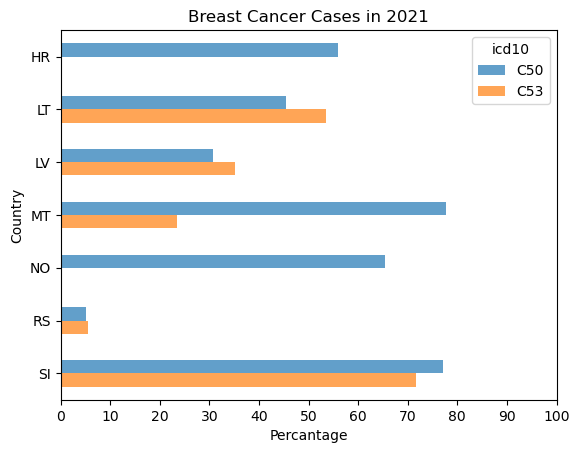

In [15]:
tidy_2021.plot.barh(alpha = 0.7)

plt.title("Breast Cancer Cases in 2021")
plt.xlabel("Percantage")
plt.ylabel("Country")
plt.xticks(range(0, 110, 10))
plt.yticks(range(0, 7), tidy_2021.index)
plt.gca().invert_yaxis()
plt.show()

*Just 7 countries are presented in the 2021 data out of 36. Slovenia shows very high number of Breast Cancer cases out of all observed - above 70%, while Serbia is on the bottom with under 10%. However we should mind the different ways in different countries the data has been collected. Also for the diagnosis have been labeled.*

**Bulgaria Numbers**

*We are interested only in Bulgaria breast cancer cases. What is the situation historically and if there is a trend that could reveals more. We assume bouth sources of information (source: PRG, SRV) are equally reliable, so we will aggregate our data by country, year and diagnosis.*

In [16]:
bc_eurostat.source.unique()

array(['PRG', 'SRV'], dtype=object)

**Functions creation**

*First function provides the data in the suitable size and type. Second function plots visuals to see the numbers.*

In [17]:
def get_cntry_cases(dataset, geo_name, icd10_name):
    """
    The function scrunch the numbers by grouping a given dataset by country name, diagnosis and year.
    It filters for specific country and diagnosis. 
    """
        
    dataset = dataset[(dataset.geo == geo_name)
                     & (dataset.icd10 == icd10_name)]
    result = dataset.groupby(by = ["geo", "icd10", "time_period"])["obs_value"].mean().round(0)
    return result

In [18]:
def plot_cases_yearly(x1, y1, x2, y2, xticks, title):
    """ 
    This is a function for plotting Breast Cancer Cases per Year.
    We are using grouped bar chart.
    x1, y1 - correspond to data for icd10 = C50
    x2, y2 - correspond to data for icd10 = C53
    """
    
    width = 0.4
    plt.figure(figsize = (8, 6))

    plt.bar(x1 - 0.2, y1, width, alpha = 0.7, label = "C50")
    plt.bar(x2 + 0.2, y2, width, alpha = 0.7, label = "C53")

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Percentage")
    plt.xticks(xticks)
    plt.yticks(range(0, 110, 10))
    plt.legend()
    plt.show()

In [19]:
# We are interested in data for Bulgaria. And separately data for both diagnosis.

bg_C50 = get_cntry_cases(bc_eurostat, "BG", "C50")
bg_C53 = get_cntry_cases(bc_eurostat, "BG", "C53")
bg_C50, bg_C53

(geo  icd10  time_period
 BG   C50    2008           22.0
             2014           32.0
             2015           14.0
             2016           21.0
             2017           21.0
             2019           36.0
 Name: obs_value, dtype: float64,
 geo  icd10  time_period
 BG   C53    2008           47.0
             2014           52.0
             2015            9.0
             2016           34.0
             2017           13.0
             2019           57.0
 Name: obs_value, dtype: float64)

In [20]:
bg_years_list_C50 = bg_C50.index.get_level_values(2)
bg_years_list_C53 = bg_C53.index.get_level_values(2)
bg_years_list_C50, bg_years_list_C50

(Int64Index([2008, 2014, 2015, 2016, 2017, 2019], dtype='int64', name='time_period'),
 Int64Index([2008, 2014, 2015, 2016, 2017, 2019], dtype='int64', name='time_period'))

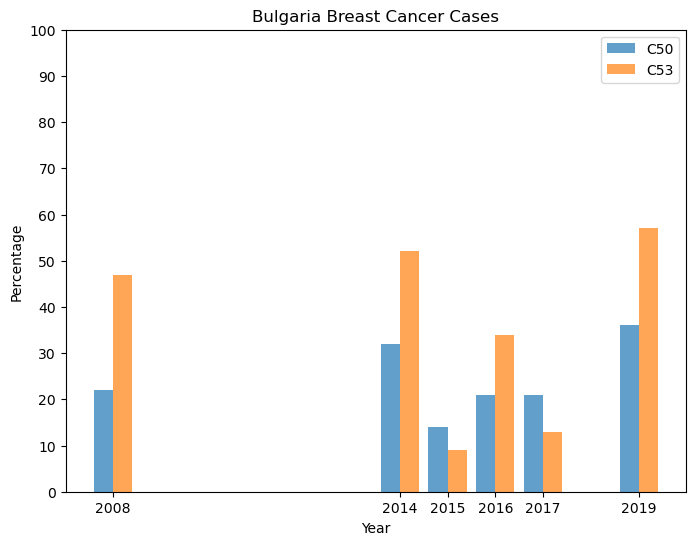

In [21]:
plot_cases_yearly(bg_years_list_C50, bg_C50, bg_years_list_C53, bg_C53, bg_years_list_C50, "Bulgaria Breast Cancer Cases")

*It is hard to analyze what we see, so let's try to compare it with something "similar".
From EU countries Slovakia is with number of population close to the Bulgarian one. According to wikipedia - 5.4 millions in 2021. And 6.5 millions for Bulgaria. Let's check the figures in Slovakia to better understand the situation in Bulgaria.*

**Slovakia Numbers**

In [22]:
# Slovakia data extraction

sk_C50 = get_cntry_cases(bc_eurostat, "SK", "C50")
sk_C53 = get_cntry_cases(bc_eurostat, "SK", "C53")
sk_C50, sk_C53

(geo  icd10  time_period
 SK   C50    2006           29.0
             2007           32.0
             2008           34.0
             2009           47.0
             2010           33.0
             2011           31.0
             2012           32.0
             2013           31.0
             2014           42.0
             2015           30.0
             2016           31.0
             2017           31.0
             2018           30.0
             2019           42.0
             2020           27.0
 Name: obs_value, dtype: float64,
 geo  icd10  time_period
 SK   C53    2009           56.0
             2010           49.0
             2011           48.0
             2012           47.0
             2013           47.0
             2014           58.0
             2015           48.0
             2016           46.0
             2017           46.0
             2018           46.0
             2019           59.0
             2020           40.0
 Name: obs_value, dtype: 

In [23]:
sk_years_list_C50 = sk_C50.index.get_level_values(2)
sk_years_list_C53 = sk_C53.index.get_level_values(2)
sk_years_list_C50, sk_years_list_C50

(Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
             2017, 2018, 2019, 2020],
            dtype='int64', name='time_period'),
 Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
             2017, 2018, 2019, 2020],
            dtype='int64', name='time_period'))

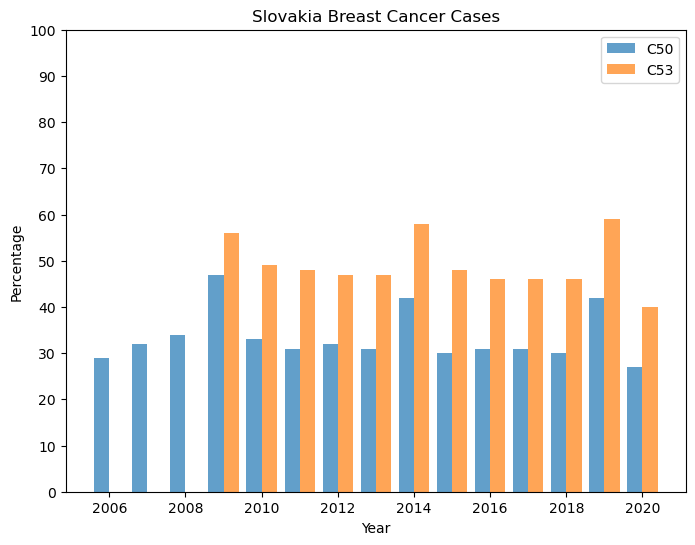

In [24]:
plot_cases_yearly(sk_years_list_C50, sk_C50, sk_years_list_C53, sk_C53, range(2006, 2021, 2), "Slovakia Breast Cancer Cases")

**Conclusion**

*Bulgaria data is not fully presented. There is a gap in data between 2009 and 2013, as well 2018. It is hard to see any trend or pattern. Unlike Slovakia there are cases of C50 that exceeds C53 in two years - 2015 and 2017. The numbers in those two years are significantly lower than the rest, which may point to gap in data collection or a bias. Unfortunately the original data is already agregated and is not compatible for further exploration on this matter.*

### Winsconsin Data

The dataset is public, available on the [UCI website](http://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) and on [kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data). There are 569 observations and 32 features. The features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

This data set was created by Dr. William H. Wolberg, physician at the University Of Wisconsin Hospital at Madison, Wisconsin,USA. To create the dataset Dr. Wolberg used fluid samples, taken from patients with solid breast masses and an easy-to-use graphical computer program called Xcyt, which is capable of perform the analysis of cytological features based on a digital scan. The program uses a curve-fitting algorithm, to compute ten features from each one of the cells in the sample, than it calculates the mean value, extreme value and standard error of each feature for the image, returning a 30 real-valuated vector.

**Attribute Information:**

1. ID number 
2. Diagnosis (M = malignant, B = benign) 
3. to 32. Ten real-valued features are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

The mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [25]:
bc_winsconsin = pd.read_csv("data\wdbc.data", header = None)

In [26]:
bc_winsconsin.shape

(569, 32)

In [27]:
# Renaming the columns to be more descriptive

col_names_winsc = ["id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"]
bc_winsconsin.columns = col_names_winsc

In [28]:
bc_winsconsin.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**Types and Null Values**

In [29]:
# Let's check types and null values

bc_winsconsin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

There are no missing values. All columns are numeric, which is great - the table looks terrific!

**What is the target frequency**

In [30]:
# Let's transform object type "diagnosis" to numerical type: 0 - benign; 1 - malignant, as this is our target variable which we will predict.

bc_winsconsin.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [31]:
dic_diagnosis = {"B": 0, "M": 1}
bc_winsconsin["diagnosis"] = bc_winsconsin["diagnosis"].map(dic_diagnosis)
bc_winsconsin.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [32]:
all = bc_winsconsin.diagnosis.count()
all_malignants = bc_winsconsin.diagnosis.sum()
all_benigns = all - all_malignants

print("Cases of benign are: ", all_benigns, ", which is ", '{:.0%}'.format(all_benigns / all))

print("Cases of malignant are: ", all_malignants, ", which is ", '{:.0%}'.format(all_malignants / all))

Cases of benign are:  357 , which is  63%
Cases of malignant are:  212 , which is  37%


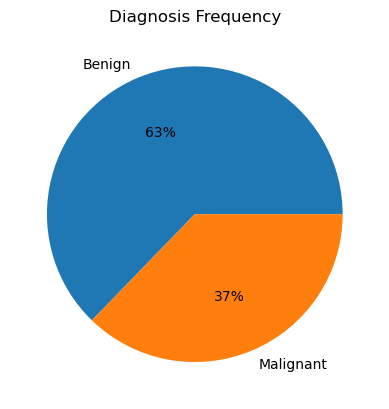

In [33]:
# Visualizing frequency of diagnosis

diagnosis_counts = bc_winsconsin.groupby(["diagnosis"]).size().sort_values(ascending = False)

plt.pie(diagnosis_counts 
        , labels = ["Benign", "Malignant"]
        , autopct='%1.0f%%'
       )

plt.title("Diagnosis Frequency")
plt.gca().set_aspect("equal")
plt.show()

**What columns' stats could tell**

In [34]:
bc_winsconsin.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave_points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01


**What is the distribution of the independent feature values**

In [35]:
# Function to extract and visualize the feature distributions

def show_distributions(dataset_name, f_name):
    """
    This function shows distribution of features/ columns per diagnosis.
    Parameter:
     - dataset_name - the dataframe, where to be looked
     - f_name - the column to be shown
    """
    B = bc_winsconsin[bc_winsconsin.diagnosis == 0][f_name]
    M = bc_winsconsin[bc_winsconsin.diagnosis == 1][f_name]
    
    plt.figure(figsize = (8, 2))
    plt.hist(B, bins = "fd", alpha = 0.7, label = "Benign")
    plt.hist(M, bins = "fd", alpha = 0.7, label = "Malignant")
    
    plt.title(f_name)
    plt.legend()
    plt.show()    

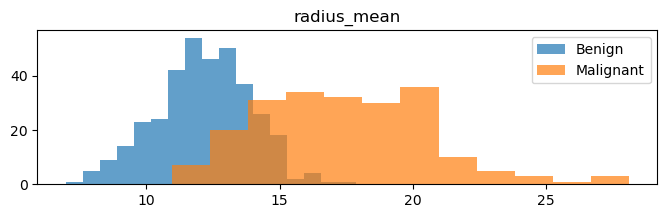

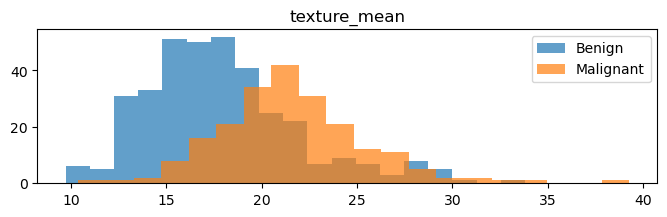

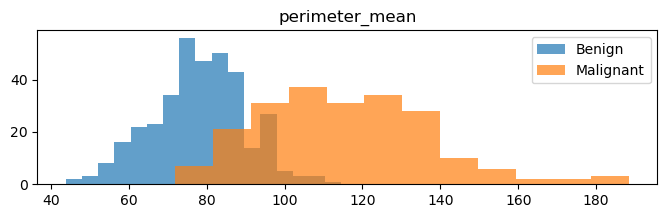

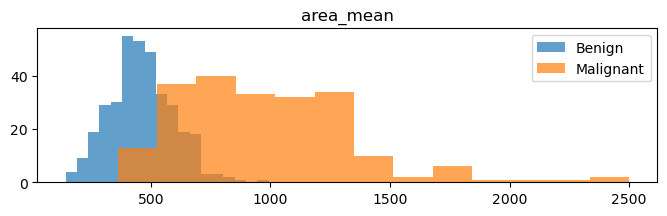

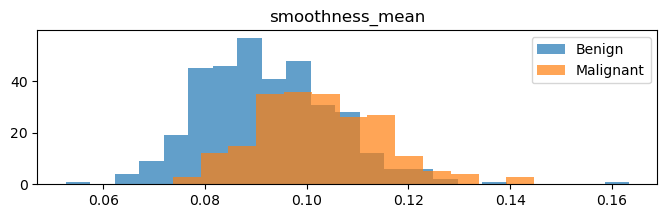

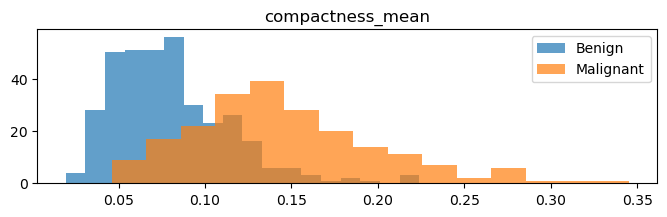

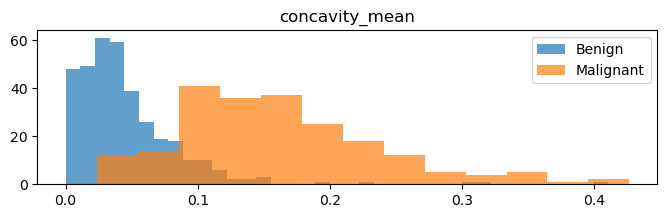

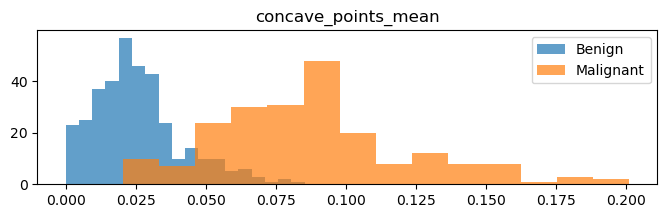

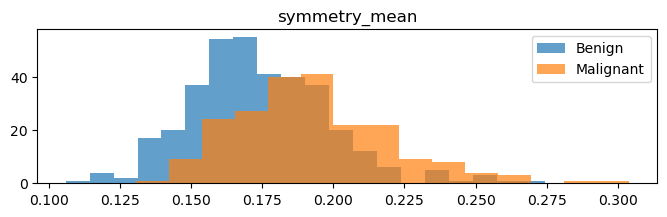

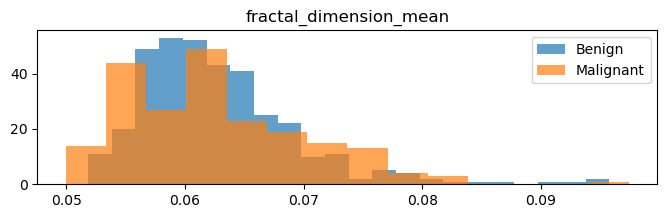

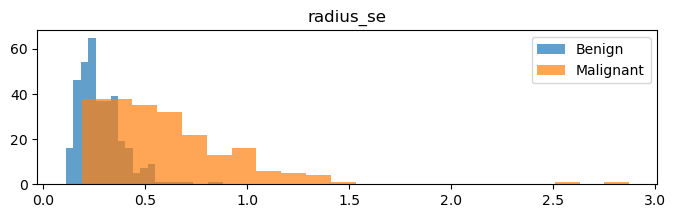

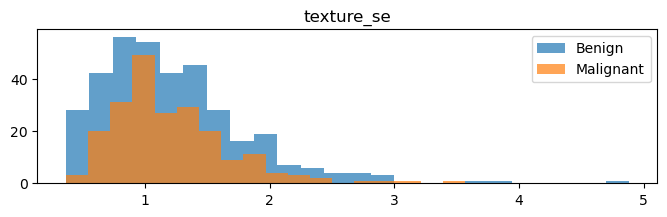

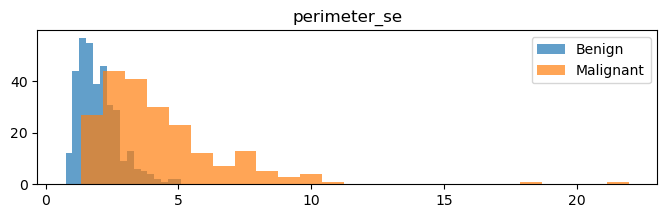

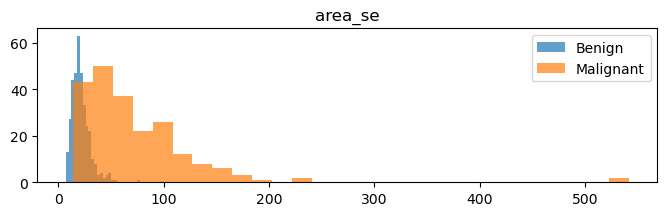

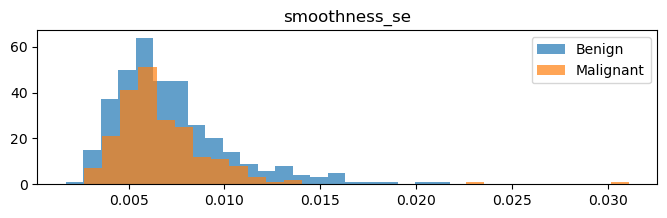

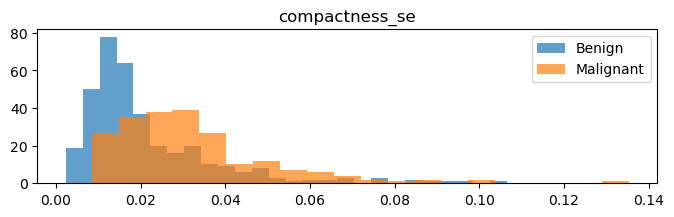

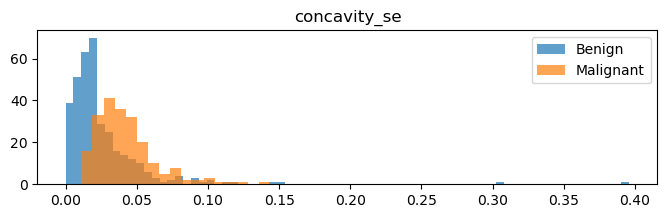

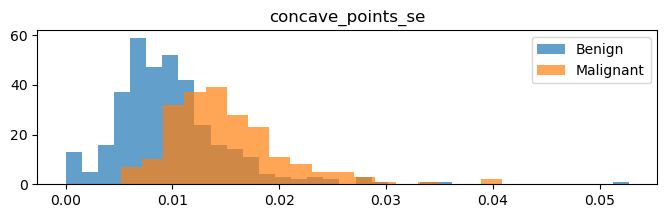

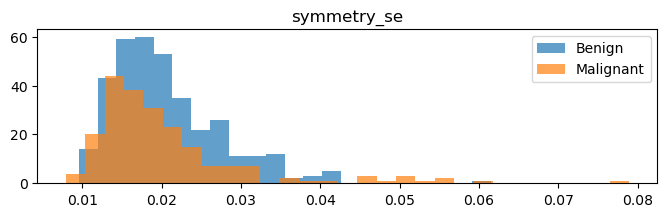

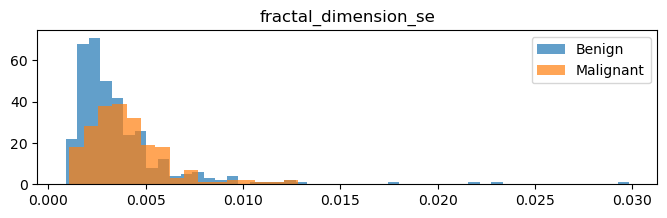

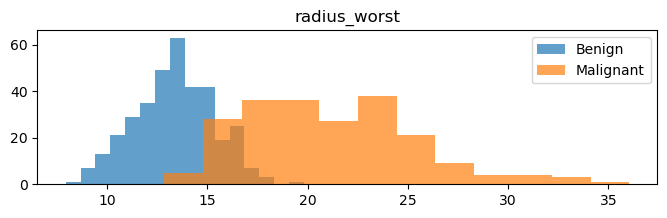

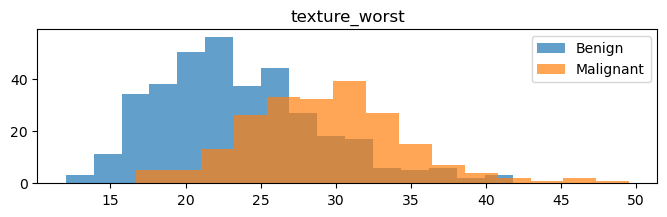

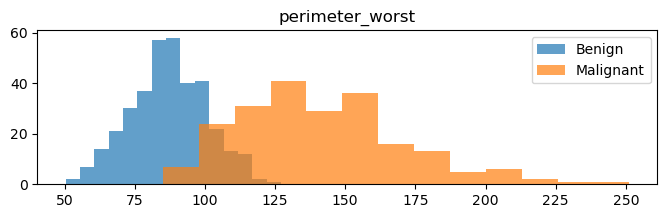

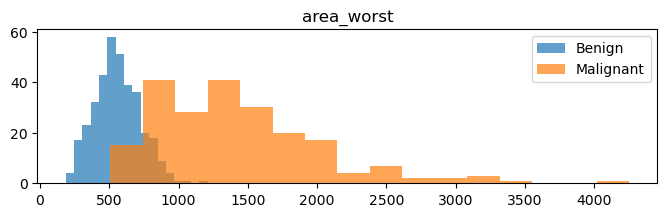

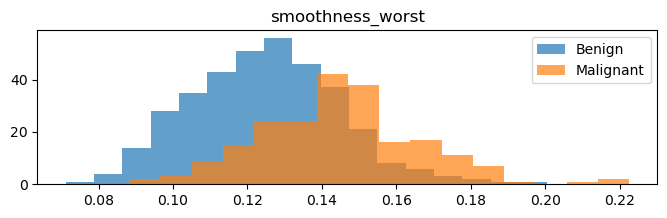

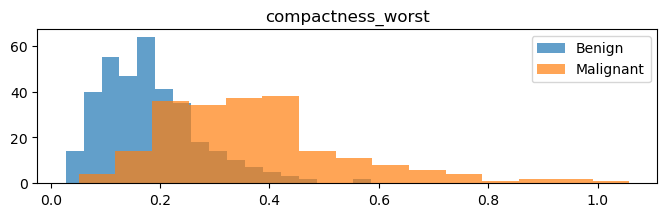

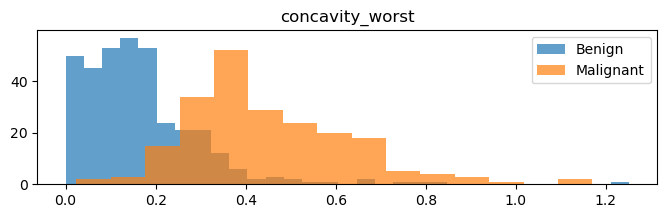

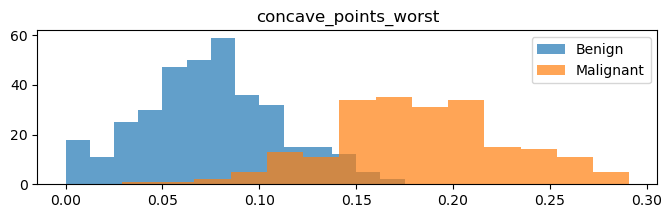

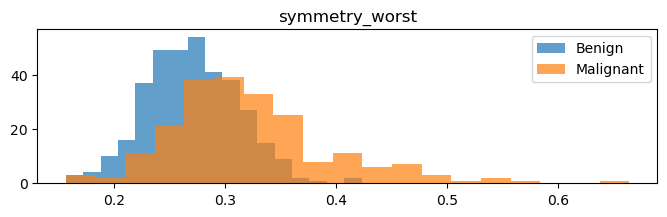

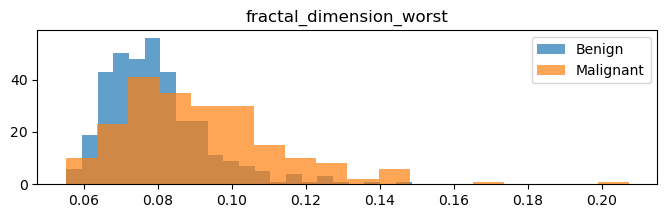

In [36]:
col_names_w_tidy = bc_winsconsin.drop(["id", "diagnosis"], axis = 1)

for column in col_names_w_tidy:
    show_distributions(bc_winsconsin, column)

**How many of the features are strongly correlated**

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

In [37]:
# Calculating Pearson correlation between columns

corr_table = bc_winsconsin.corr().unstack().sort_values().drop_duplicates()

# Extract columns with higher than 0.9 correlation

highly_corr_features = corr_table[corr_table > 0.9].index.get_level_values(0).to_list()

#Removing duplicates

highly_corr_features = list(set(highly_corr_features))
print("Highly correlated columns are ", len(highly_corr_features))

Highly correlated columns are  12


In [38]:
# Feature selection - 20 columns were left out of 32

lin_indep_features = bc_winsconsin.drop(highly_corr_features, axis = 1)
lin_indep_features.head()

,diagnosis,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,perimeter_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,0.11840,0.27760,0.2419,0.07871,0.9053,8.589,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,17.33,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,0.08474,0.07864,0.1812,0.05667,0.7339,3.398,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,0.10960,0.15990,0.2069,0.05999,0.7869,4.585,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,0.14250,0.28390,0.2597,0.09744,1.1560,3.445,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,26.50,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,0.10030,0.13280,0.1809,0.05883,0.7813,5.438,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Principal Component Analysis

In [39]:
pca = PCA()
pca.fit(bc_winsconsin)

t_matrix = pca.components_
t_matrix.shape

(32, 32)

We received a matrix 32 x 32. This is our T matrix. What we did is to change our basis. We multipy with lambda all variables to receive the new basis.

In [40]:
t_matrix[:, 1]

array([ 1.53932217e-10,  5.35401985e-04, -2.27188067e-04, -1.68164316e-03,
       -2.25443731e-02,  4.69509523e-03,  5.73921030e-03,  1.95092333e-02,
        7.85115756e-03, -1.62760658e-01, -5.94561407e-01,  6.99414321e-01,
       -3.57849576e-01,  1.48072351e-02,  7.72269862e-04, -2.79463287e-02,
        7.87103597e-03,  2.14058953e-02,  1.25307403e-02,  3.48850111e-03,
        2.02627899e-03,  4.09989053e-03,  4.65601036e-03, -4.08616426e-03,
        2.96232153e-03, -4.42125852e-04,  2.21427561e-04, -7.41657009e-04,
       -1.00325285e-03, -3.22204955e-04, -3.99090592e-04,  9.71252754e-05])

In [41]:
changed_basis = pca.explained_variance_ratio_
changed_basis

array([1.00000000e+00, 2.80767974e-11, 4.67287346e-13, 4.38515079e-14,
       3.49762899e-15, 2.52779078e-15, 1.92223783e-16, 1.15891183e-16,
       2.34961145e-17, 1.00821182e-17, 5.72323853e-18, 4.88289927e-18,
       1.54446571e-18, 4.77871167e-19, 2.02224720e-19, 1.35176011e-19,
       8.46112966e-20, 3.90775100e-20, 2.33705414e-20, 1.50023153e-20,
       1.17881198e-20, 1.04139236e-20, 4.89632538e-21, 3.62857103e-21,
       2.20379283e-21, 1.81566585e-21, 1.03285970e-21, 7.97171089e-22,
       2.29218339e-22, 1.81687487e-22, 1.27479077e-22, 4.48445497e-23])

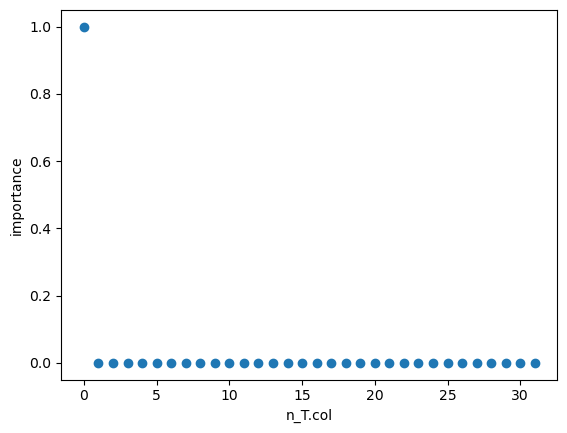

In [42]:
plt.scatter(range(len(changed_basis)), changed_basis)
# plt.xlim(0, 20)
# plt.ylim(0, 1.1)
plt.xlabel("n_T.col")
plt.ylabel("importance")

plt.show()

Wow! It looks that first feature explains 100% of all information in our dataset. Let's reduce dimenstionality by cutting the features to 1.

In [43]:
pca = PCA(1)
pca.fit(bc_winsconsin)
transformed_data = pca.transform(bc_winsconsin)
transformed_data.shape

(569, 1)

In [44]:
# Print transformed data

transformed_data = pd.DataFrame(transformed_data)
transformed_data.head()

,0
0,-2.952953e+07
1,-2.952931e+07
2,5.392907e+07
3,5.397647e+07
4,5.398657e+07


**PCA of selected independent features**

In [45]:
pca = PCA()
pca.fit(lin_indep_features)

t_matrix = pca.components_
t_matrix.shape

(20, 20)

We received a matrix 20 x 20. This is our T matrix. What we did is to change our basis. We multipy with lambda all variables to receive the new basis.

In [46]:
t_matrix[:, 1]

array([ 1.01573940e-04,  2.13057458e-03, -2.80029657e-03,  1.48126422e-02,
        2.32061372e-02, -5.55720794e-02,  2.54850596e-02, -2.52892210e-01,
        1.09860822e-01, -3.16342412e-01,  8.74616186e-02,  1.71835866e-02,
       -1.74230689e-01,  2.64464194e-01, -8.09348652e-01, -2.15014623e-01,
        3.74842286e-02,  2.84102488e-02,  8.74410023e-02, -4.29111155e-03])

In [47]:
changed_basis = pca.explained_variance_ratio_
changed_basis

array([8.96160176e-01, 9.34733034e-02, 6.91341023e-03, 2.43653236e-03,
       8.16077673e-04, 9.54131395e-05, 5.17287294e-05, 1.88614922e-05,
       1.21597187e-05, 9.29792066e-06, 5.42087312e-06, 3.82048174e-06,
       1.66270453e-06, 8.41977013e-07, 6.29616168e-07, 3.68672964e-07,
       1.20274578e-07, 1.00293068e-07, 5.58534291e-08, 1.89207126e-08])

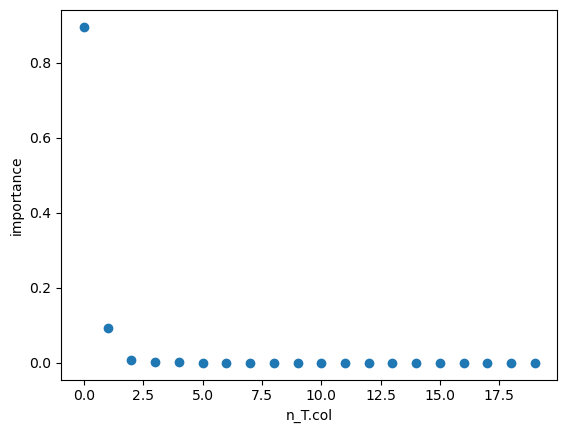

In [48]:
plt.scatter(range(len(changed_basis)), changed_basis)
# plt.xlim(0, 20)
# plt.ylim(0, 1.1)
plt.xlabel("n_T.col")
plt.ylabel("importance")

plt.show()

Wow! It looks that first feature explains 89.6% of all information in our dataset. First and second features explain 0.9896 of data variance. Let's reduce dimenstionality by cutting the features to two.

In [49]:
pca = PCA(2)
pca.fit(lin_indep_features)
transformed_data = pca.transform(lin_indep_features)
transformed_data.shape

(569, 2)

In [50]:
# Print transformed data

transformed_data = pd.DataFrame(transformed_data)
transformed_data.head()

,0,1
0,-7.866144,6.413679
1,-2.213885,0.759644
2,-0.007607,1.780873
3,0.896044,0.612077
4,-8.770531,3.321990
